In [1]:
import pandas as pd
import torch
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg
from matplotlib.figure import Figure
from matplotlib import font_manager as fm
import networks
import mne
import mne_rsa
import editdistance
from pilot import utils
from scipy.spatial import distance
import seaborn as sns
import pickle
from tqdm import tqdm
from io import BytesIO
import os
import contextlib
import imageio
from joblib import Parallel, delayed
from tqdm import tqdm

In [2]:
dsms_file = np.load('pilot2_dsms.npz')
meg_dsms = dsms_file['dsms']

# Get CNNs Model Trained

### Load images

In [3]:
meta = pd.read_csv("pilot2-stimuli-metadata.csv")
meta

,text,type,freq,font,fontsize,rotation,noise_level,filename,question,question_correct,question_filename,event_id,question_asked,y
0,odote,word,20.0,Comic Sans MS,20.0,0.0,0.5,word_odote.png,_ _ _ _ j,False,word_odote_question.png,10.0,False,0
1,nurin,word,1001.0,Times New Roman,20.0,-15.0,0.5,word_nurin.png,_ _ _ _ l,False,word_nurin_question.png,10.0,False,1
2,nurja,word,11.0,Times New Roman,30.0,-15.0,0.5,word_nurja.png,_ _ _ _ a,True,word_nurja_question.png,10.0,False,2
3,näkö,word,506.0,Times New Roman,30.0,-15.0,0.5,word_näkö.png,n _ _ _,True,word_näkö_question.png,10.0,False,3
4,näppy,word,15.0,Impact,30.0,0.0,0.5,word_näppy.png,_ _ u _ _,False,word_näppy_question.png,10.0,True,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,ds^^o,symbols,NaN,DejaVu Sans,40.0,0.0,0.5,symbols_ds^^o.png,_ s _ _ _,True,symbols_ds^^o_question.png,30.0,False,355
356,dsdoo^,symbols,NaN,DejaVu Sans,30.0,0.0,0.5,symbols_dsdoo^.png,_ _ _ v _ _,False,symbols_dsdoo^_question.png,30.0,False,356
357,dsovsd,symbols,NaN,DejaVu Sans,40.0,15.0,0.2,symbols_dsovsd.png,_ _ _ _ _ ^,False,symbols_dsovsd_question.png,30.0,False,357
358,ssods,symbols,NaN,DejaVu Sans,40.0,-15.0,0.5,symbols_ssods.png,_ _ _ d _,True,symbols_ssods_question.png,30.0,True,358


In [4]:
images = torch.zeros((360, 3, 60, 60))
preproc = transforms.Compose([
    transforms.CenterCrop(208),
    transforms.Resize(64),
    transforms.CenterCrop(60),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

for i in range(len(meta['filename'])):
    image_name = meta['filename'][i]
    with Image.open(f'stimuli/{image_name}') as image:
        image = image.convert('RGB')
        image = preproc(image).unsqueeze(0)
        if image.shape[1] == 1:
            image = image.repeat(1, 3, 1, 1)
        images[i] = image

### Load model and get DSMs

In [5]:
# Load the model and feed through the images
model_name = 'vgg_first_imagenet64_then_tiny-words-noisy_tiny-imagenet'
checkpoint = torch.load('%s.pth.tar' % model_name, map_location='cpu')
model = networks.vgg.from_checkpoint(checkpoint)
with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
    feature_outputs, classifier_outputs = model.get_layer_activations(images)

# calculate DSMs
dsms_values = [
    mne_rsa.compute_dsm(feature_outputs[0], metric='correlation'),
    mne_rsa.compute_dsm(feature_outputs[1], metric='correlation'),
    mne_rsa.compute_dsm(feature_outputs[2], metric='correlation'),
    mne_rsa.compute_dsm(feature_outputs[3], metric='correlation'),
    mne_rsa.compute_dsm(classifier_outputs[0], metric='correlation'),
    mne_rsa.compute_dsm(classifier_outputs[1], metric='correlation'),
    mne_rsa.compute_dsm(classifier_outputs[2], metric='correlation'),
]

In [6]:
dims = meg_dsms.shape
meg_dsms_flat = meg_dsms.reshape(-1, dims[-1])

In [9]:
def proc(meg, model, metric):
    return mne_rsa.rsa(meg, model, metric=metric)

def dsm_gen(dsms):
    for dsm in dsms:
        yield dsm
    
dsm_data = [meg_dsms_flat[i] for i in range(len(meg_dsms_flat))]
rsa_results = Parallel(n_jobs=-1)([delayed(proc)(dsm, dsms_values, "spearman") for dsm in dsm_gen(dsm_data)])
rsa_results = np.array(rsa_results).reshape(202, 71, 7)

In [10]:
# Pack the RSA results into an MNE-Python Evoked object in order to visualize it
info = mne.io.read_info('info_template.fif')  # Contains sensor names and locations

    Read a total of 13 projection items:
        generated with autossp-1.0.1 (1 x 306) active
        generated with autossp-1.0.1 (1 x 306) active
        generated with autossp-1.0.1 (1 x 306) active
        generated with autossp-1.0.1 (1 x 306) active
        generated with autossp-1.0.1 (1 x 306) active
        generated with autossp-1.0.1 (1 x 306) active
        generated with autossp-1.0.1 (1 x 306) active
        generated with autossp-1.0.1 (1 x 306) active
        generated with autossp-1.0.1 (1 x 306) active
        generated with autossp-1.0.1 (1 x 306) active
        generated with autossp-1.0.1 (1 x 306) active
        generated with autossp-1.0.1 (1 x 306) active
        generated with autossp-1.0.1 (1 x 306) active


In [18]:
np.save("rsa_results", rsa_results)

In [15]:
rsa_results_mne = dict()
for i in range(7):
    rsa_results_mne[i] = mne.EvokedArray(rsa_results[:, :, i], info, tmin=dsms_file['times'][0])

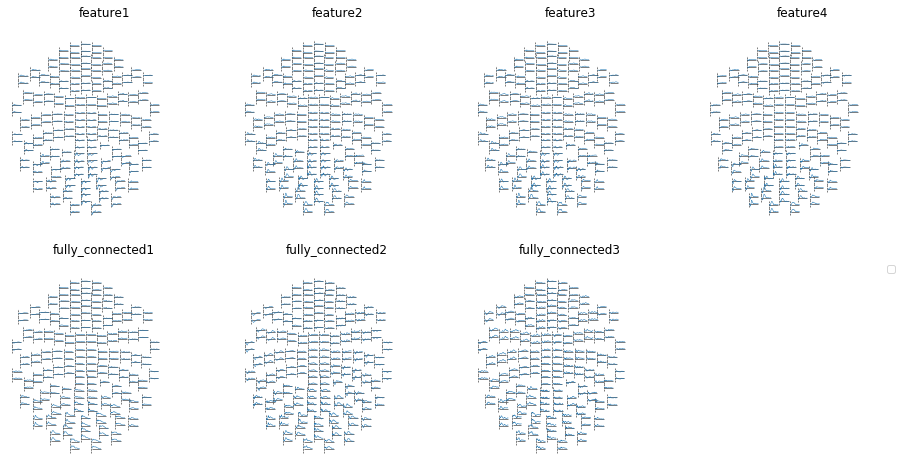

In [52]:
keys = ["feature1", "feature2", "feature3", "feature4", "fully_connected1", "fully_connected2", 
        "fully_connected3"]

# Plot
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes[-1, -1].set_axis_off()
for i in range(7):
    rsa_results_mne[i].plot_topo(axes=axes[i//4, i%4], show=False)
    axes[i//4, i%4].set_title(f"{keys[i]}")
plt.savefig("meg_rsa.pdf")

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


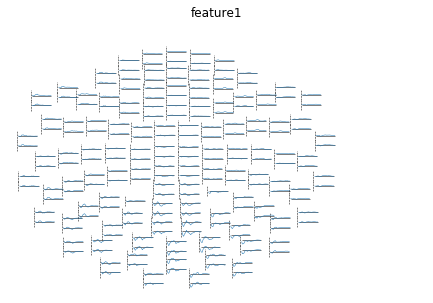

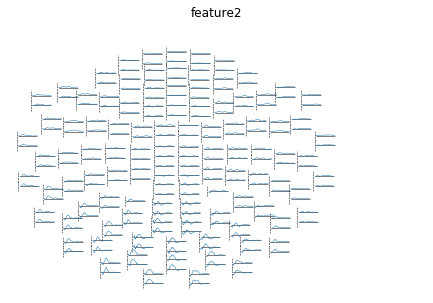

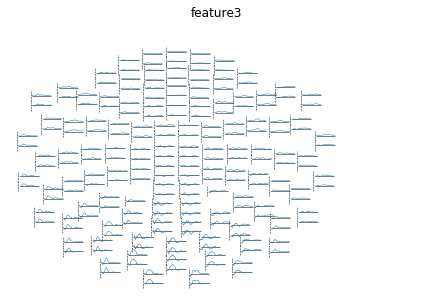

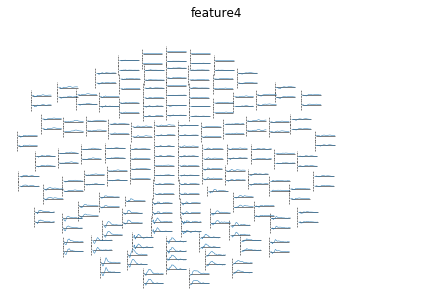

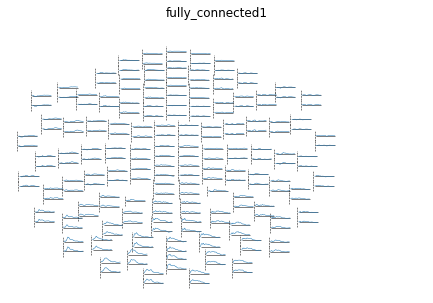

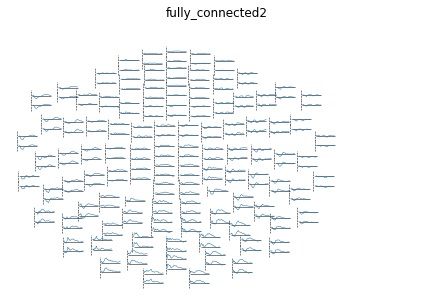

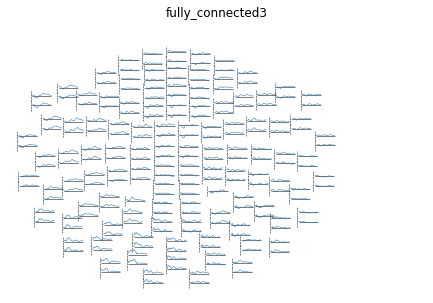

In [54]:
mne_plots = dict()
for i in range(7):
    mne_plots[i] = rsa_results_mne[i].plot_topo(show=False)
    plt.title(f"{keys[i]}")
    plt.legend().remove()
    plt.savefig(f"meg_rsa_{keys[i]}.pdf")